<a href="https://colab.research.google.com/github/YUseiDoi/HMM/blob/main/HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Modules

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

## Import Seq Data

In [ ]:
file_path = '/content/gdrive/MyDrive/研究/M1-2/HMM課題/seq.csv'

with open(file_path) as fp:
    reader = csv.reader(fp)
    data = [ e for e in reader ]

seq = np.array(data).reshape(-1)

In [ ]:
seq

array(['6', '2', '5', ..., '1', '2', '2'], dtype='<U1')

## バウムウェルチアルゴリズム

In [ ]:
# 初期化

# 遷移確率
A = np.array([[0.7, 0.3], [0.4, 0.6]])
# 出力確率
B = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6], [1/3, 2/15, 2/15, 2/15, 2/15, 2/15]])
# 初期状態確率
p = np.array([0.7, 0.3])
# 状態数
state_num = 2
# 出力数
output_num = 6
# 観測系列の長さ
seq_len = len(seq)

# 予測したパラメータ変数の初期化
A_pred = np.zeros((state_num, state_num))
B_pred = np.zeros((state_num, output_num))
p_pred = np.zeros(state_num)

# 初期状態確率
gamma = np.zeros((state_num, seq_len))
epsilon = np.zeros((state_num, state_num, seq_len))

# 対数尤度の更新幅の閾値
likelihood_threshold = 1e-9

100%|██████████| 200/200 [02:11<00:00,  1.53it/s]


[[0.90854386 0.09145614]
 [0.04984343 0.95015657]]
[[0.16596811 0.16932874 0.15505014 0.16031835 0.17774156 0.17159311]
 [0.59908535 0.07388876 0.09343708 0.07880951 0.07841646 0.07636283]]
[1.00000000e+00 3.54679865e-65]
-15514.758863729601


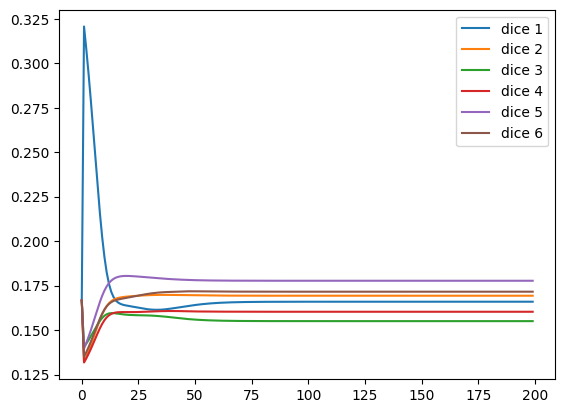

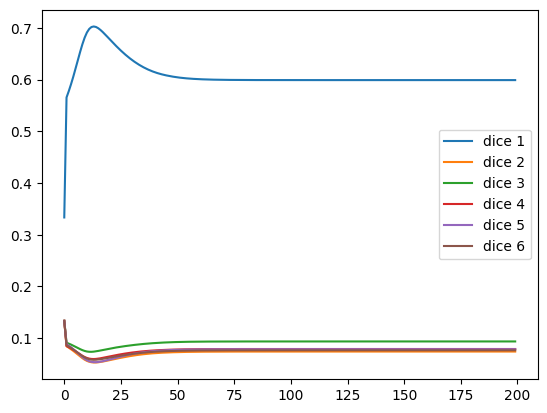

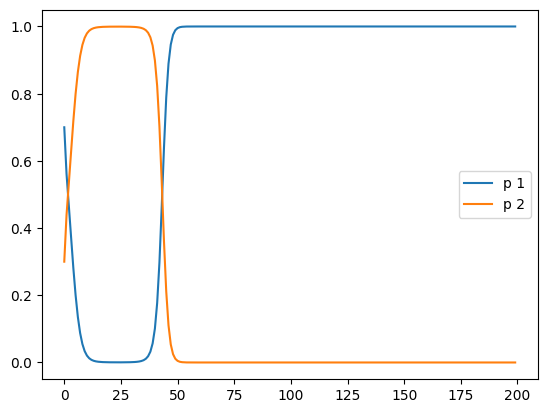

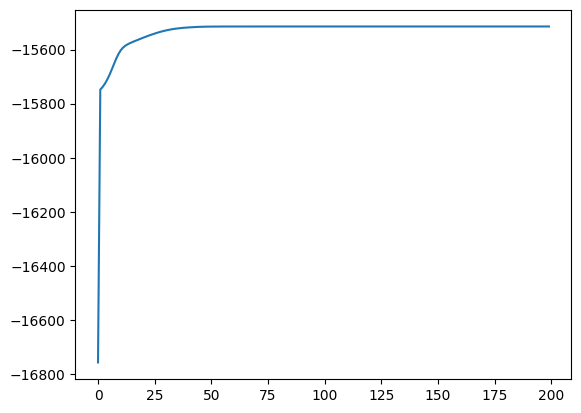

In [ ]:
# パラメータの推定
# 対数尤度の更新幅が閾値を越えなければ終了
# 参考：https://qiita.com/taka256/items/3e5306d0432c05909992
#      http://unicorn.ike.tottori-u.ac.jp/murakami/doctor/node15.html
loop_counter = 0
Px_log_old = 1e-9

fig, ax = plt.subplots()

A_plot = [[] for _ in range(state_num)]
B0_plot = [[] for _ in range(output_num)]
B1_plot = [[] for _ in range(output_num)]
p_plot = [[] for _ in range(state_num)]
log_likelihood_plot = []

for loop_count in tqdm(range(0, 200)):

  # グラフ描画用にBを保存
  for i in range(0, output_num):
    B0_plot[i].append(B[0][i])
    B1_plot[i].append(B[1][i])

  for i in range(0, state_num):
    p_plot[i].append(p[i])

  ############################
  # 1. 初期化

  # α_hatの初期化
  alpha_hat = np.zeros((state_num, seq_len))    # α_hat
  for i in range(0, state_num):
    alpha_hat[i][0] = p[i] * B[i][0]

  # スケーリング項cの初期化
  c = np.zeros(seq_len)
  c[0] = np.sum(alpha_hat[:, 0])

  # α_hatの初期値をスケーリング
  alpha_hat[:, 0] /= c[0]

  # β_hatの初期化
  beta_hat = np.zeros((state_num, seq_len))    # β_hat

  ############################

  ############################
  # 2. 再帰計算

  # 前向き・後向きアルゴリズムで α_hat, β_hat を計算する
  # α_hat の計算(スケーリング)
  for t in range(1, seq_len):
    for j in range(0, state_num):
      tmp_sum = 0
      for i in range(0, state_num):
        tmp_sum += alpha_hat[i][t - 1] * A[i][j]
      alpha_hat[j][t] = tmp_sum * B[j][int(seq[t]) - 1]
      c[t] += alpha_hat[j][t]
    for j in range(0, state_num):
      alpha_hat[j][t] /= c[t]

  # β_hatの計算
  for i in range(0, state_num):
    beta_hat[i][seq_len - 1] = c[seq_len - 1]

  for t in range(seq_len - 2, -1, -1):
    for i in range(0, state_num):
      for j in range(0, state_num):
        beta_hat[i][t] += A[i][j] * B[j][int(seq[t + 1]) - 1] * beta_hat[j][t + 1]
    for i in range(0, state_num):
      beta_hat[i][t] /= c[t + 1]

  # γとεの計算
  for t in range(0, seq_len):
    for i in range(0, state_num):
      gamma[i][t] = alpha_hat[i][t] * beta_hat[i][t]
      for j in range(0, state_num):
        if t != seq_len - 1: epsilon[i][j][t] = alpha_hat[i][t] * A[i][j] * B[j][int(seq[t + 1]) - 1] * beta_hat[j][t + 1] / c[t + 1]

  ############################

  ############################
  # 3. パラメータ計算

  # A, B, ρの予測値の計算
  # A
  for i in range(0, state_num):
    for j in range(0, state_num):
      gamma_sum_except_last = 0
      epsilon_sum_except_last = 0
      for t in range(0, seq_len - 1):
        gamma_sum_except_last += gamma[i][t]
        epsilon_sum_except_last += epsilon[i][j][t]
      A_pred[i][j] = epsilon_sum_except_last / gamma_sum_except_last

  # B
  for i in range(0, state_num):
    for k in range(0, output_num):
      gamma_sum = 0
      gamma_del_sum = 0
      for t in range(0, seq_len):
        gamma_sum += gamma[i][t]
        if (int(seq[t]) - 1) == k:
          gamma_del_sum += gamma[i][t]
      B_pred[i][k] = gamma_del_sum / gamma_sum

  # ρ
  for i in range(0, state_num):
    p_pred[i] = gamma[i][0] / c[seq_len - 1]

  ############################

  ############################
  # 4. パラメータ更新

  # A, B, ρ の更新
  A = np.copy(A_pred)
  B = np.copy(B_pred)
  p = np.copy(p_pred)

  #from IPython.core.debugger import Pdb; Pdb().set_trace()
  ############################

  ############################
  # 5. 終了判定

  # 対数尤度の計算
  Px_log = 0
  for i in range(0, seq_len):
    Px_log += math.log(c[i])
  log_likelihood_plot.append(Px_log)

  # 対数尤度が閾値を越える   → パラメータを更新
  # 対数尤度が閾値を越えない → ループ終了
  #if Px_log - Px_log_old < math.log(likelihood_threshold):
    #break

Px_log_old = Px_log
print(A)
print(B)
print(p)
print(Px_log)

for i in range(len(B0_plot)):
    plt.plot(B0_plot[i], label=f'dice {(i + 1)}')
plt.legend()
plt.show()

for i in range(len(B1_plot)):
    plt.plot(B1_plot[i], label=f'dice {(i + 1)}')
plt.legend()
plt.show()

for i in range(len(p_plot)):
    plt.plot(p_plot[i], label=f'p {(i + 1)}')
plt.legend()
plt.show()

plt.plot(log_likelihood_plot)
plt.show()

  ############################





## ビタービアルゴリズム

In [ ]:
# 配列をcsvとして保存する
def save_array_as_csv(arr, file_name = "output"):
  np.savetxt('/content/gdrive/MyDrive/研究/M1-2/HMM課題/' + file_name + '.csv', arr, delimiter=',')
  print("save complete")

In [ ]:
# ビタビアルゴリズム
class Viterbi:
  def __init__(self, A, B, p, state_num, seq):
    self._A = A    # 遷移確率
    self._B = B    # 出力確率
    self._p = p    # 初期確率
    self._state_num = state_num     # 状態数
    self._seq = seq     # 観測系列

    self._hidden_state = np.zeros(seq_len)   # 推定した隠れ状態

    self._log_likelihood = []    # 対数尤度

    self.EPS = -10000000000

    # ψ -> psi_s
    # Ψ -> psi_l
    self._psi_s = np.zeros((state_num, seq_len))     # ψ
    self._psi_l = np.zeros((state_num, seq_len))     # Ψ
    for i in range(0, state_num):
      self._psi_s[i][0] = p[i] * B[i][int(seq[0]) - 1]

  @property
  def psi_s(self):
    return self._psi_s

  @property
  def psi_l(self):
    return self._psi_l

  @property
  def hidden_state(self):
    return self._hidden_state

  # 再帰的計算（対数変換なし）
  def forward(self):
    for t in range(1, len(self._seq)):
      for j in range(0, self._state_num):
        max_probability = -1
        max_probability_idx = -1
        for i in range(0, self._state_num):
          if self._psi_s[i][t - 1] * self._A[i][j] > max_probability:
            max_probability = self._psi_s[i][t - 1] * self._A[i][j]
            max_probability_idx = i
        self._psi_s[j][t] = max_probability * self._B[j][int(self._seq[t]) - 1]
        self._psi_l[j][t] = max_probability_idx

  # 再帰的計算（対数変換あり）
  def forward_log(self):
    for i in range(0, state_num):
      self._psi_s[i][0] = math.log(self._p[i]) + math.log(self._B[i][0])
    max_likelihood = self.EPS
    for t in tqdm(range(1, len(self._seq))):
      for j in range(0, self._state_num):
        max_probability = self.EPS
        max_probability_idx = -1
        for i in range(0, self._state_num):
          prob = self._psi_s[i][t - 1] + math.log(self._A[i][j]) + math.log(self._B[j][int(self._seq[t]) - 1])
          if prob > max_probability:
            max_probability = prob
            max_probability_idx = i
        self._psi_s[j][t] = max_probability
        self._psi_l[j][t] = max_probability_idx
        if self._psi_s[j][t] > max_likelihood:
          max_likelihood = self._psi_s[j][t]
      #print(max_probability_idx)
      self._log_likelihood.append(self._psi_s[j][t])
    #print(self._log_likelihood)

  # 隠れ状態の復元
  def restore_hidden_state(self):
    # 最後の状態
    last_state = -1
    max_psi_s_n = self.EPS
    for i in range(0, self._state_num):
      if self._psi_s[i][len(self._seq) - 1] > max_psi_s_n:
        max_psi_s_n = self._psi_s[i][len(self._seq) - 1]
        last_state = i
    self._hidden_state[len(self._seq) - 1] = last_state

    # 最後の状態から隠れ状態を復元する
    curr_state = int(last_state)
    for t in range(len(self._seq) - 2, -1, -1):
      self._hidden_state[t] = self._psi_l[curr_state][t]
      curr_state = int(self._psi_l[curr_state][t])

  # 対数尤度のグラフ表示
  def show_log_likelihood(self):
    fig = plt.figure(figsize=(10, 4))
    print(self._log_likelihood)
    plt.plot(self._log_likelihood)
    plt.show()

  # 状態の確認
  def check_hidden_state(self, plot_start=0, plot_end=9999):
    # 状態数のカウント
    for i in range(0, self._state_num):
      count = np.sum(self._hidden_state == i)
      print("state " + str(i) + ": " + str(count))
    # 状態のグラフ
    plt.figure(figsize=(12,3))
    plt.plot(self._hidden_state[plot_start:plot_end])

100%|██████████| 9999/9999 [00:00<00:00, 76207.55it/s]


[0. 0. 0. ... 1. 1. 1.]
state 0: 3089
state 1: 6911
None
save complete


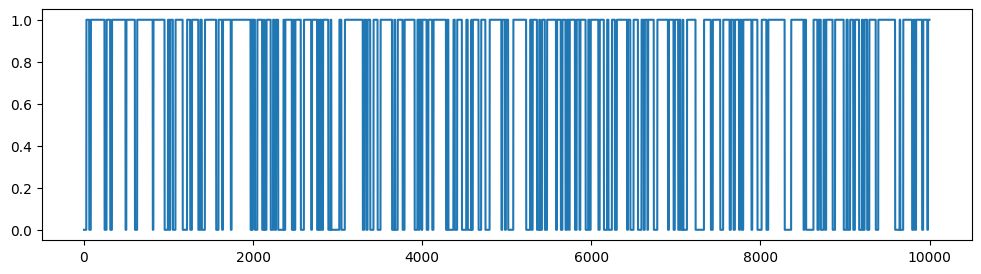

In [ ]:
my_viterbi = Viterbi(A, B, p, state_num, seq)
my_viterbi.forward_log()
my_viterbi.restore_hidden_state()
print(my_viterbi.hidden_state)
print(my_viterbi.check_hidden_state())
#my_viterbi.show_log_likelihood()
save_array_as_csv(my_viterbi.hidden_state)

state 0: 3089
state 1: 6911
None


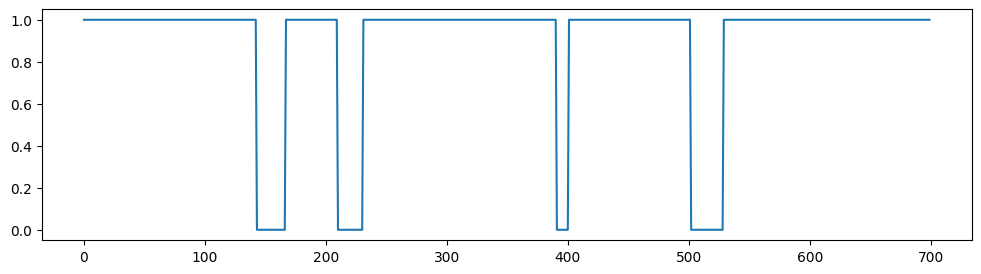

In [ ]:
print(my_viterbi.check_hidden_state(100, 800))

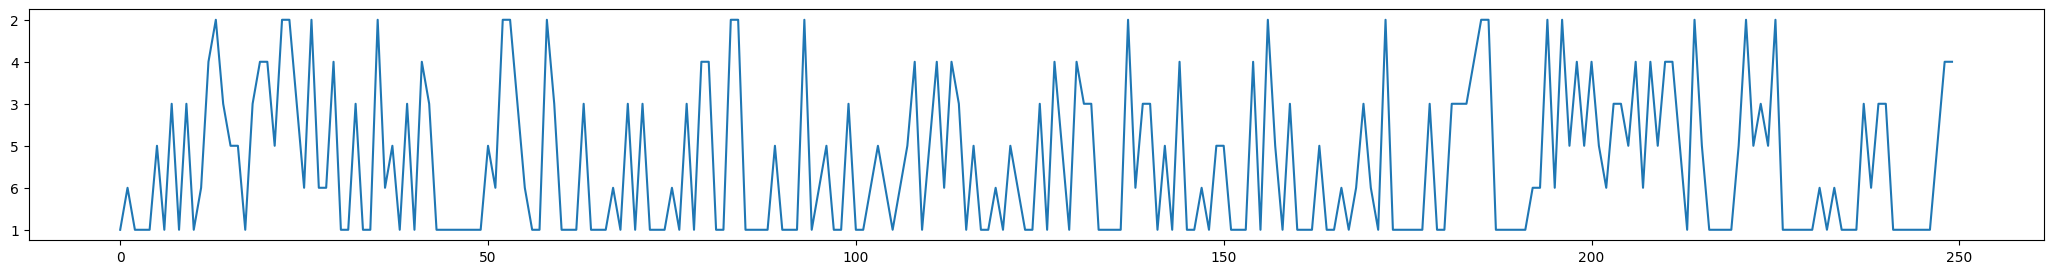

In [ ]:
fig = plt.figure(figsize=(26, 3))
plt.plot(seq[50:300])
plt.show()